# Investigating the influence of the kernelwidth used to select replacement edges in the greedy topology optimization

The data which is evaluated here was generated using `/experiments/exp_kernelwidth_topology_optimization`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

from iterative_geometry_solver import iterative_geometry_solver

In [10]:
kernel_width_arr = np.array([0.1, 0.5, 1, 2, 3, 4, 5, 10])
# num_terminals_arr = np.array([10, 20, 30, 50, 70, 100, 150])
num_terminals_arr = np.array([10, 20, 30, 50, 70])
num_problems = 50

mean_cost_arr = np.zeros((len(num_terminals_arr),len(kernel_width_arr)))
mean_iter_arr = np.zeros((len(num_terminals_arr),len(kernel_width_arr)))
std_cost_arr = np.zeros((len(num_terminals_arr),len(kernel_width_arr)))
std_iter_arr = np.zeros((len(num_terminals_arr),len(kernel_width_arr)))

for i,num_terminals in enumerate(num_terminals_arr):
    
    #load data:
    pkl_file_path = f"../results/output_files/kernelwidth_alpha_results/MC_star_kernelwidth_alpha_probs{num_problems}_size{num_terminals}_new.pkl"
    pkl_file = open(pkl_file_path, 'rb')
    large_results_dict = pickle.load(pkl_file)
    pkl_file.close()
    
    all_costs_list = []
    all_iters_list = []
    full_cost_arr = np.zeros((len(kernel_width_arr ), num_problems))
    full_iter_arr = np.zeros((len(kernel_width_arr ), num_problems))
    
    for thread_dict in large_results_dict:
        for key in thread_dict:
            all_costs_list.append(thread_dict[key]["average_costs_wrt_width"])
            all_iters_list.append(thread_dict[key]["average_iters_wrt_width"])            
    
    # first stack then average:
    all_costs_arr = np.stack(all_costs_list)
    all_iters_arr = np.stack(all_iters_list)
    
    mean_cost_arr[i,:] = np.mean(all_costs_arr, axis=0)  # average over different problem instances
    std_cost_arr[i,:] = np.std(all_costs_arr, axis=0) 
    mean_iter_arr[i,:] = np.mean(all_iters_arr, axis=0)
    std_iter_arr[i,:] = np.std(all_iters_arr, axis=0)    

## Comparison of the final cost (quality of the heuristic solution)

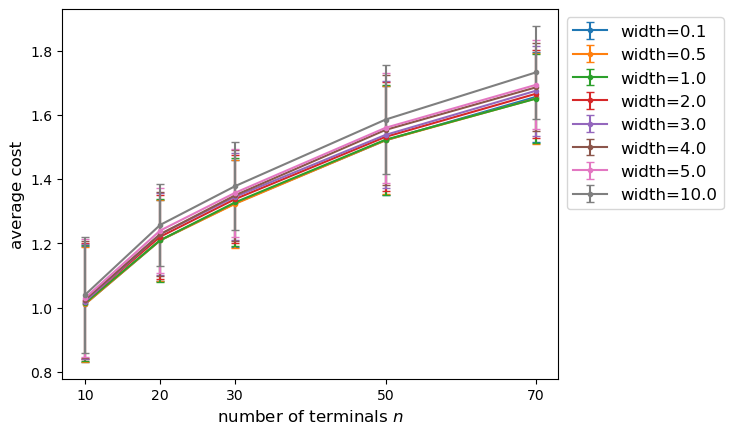

In [11]:
for j,kernel_width in enumerate(kernel_width_arr):
    plt.errorbar(num_terminals_arr, mean_cost_arr[:,j], yerr=std_cost_arr[:,j], fmt=".-", capsize=3, label=f"width={kernel_width}")

plt.legend(fontsize= 12, bbox_to_anchor=(1, 1))
plt.ylabel("average cost", fontsize= 12)
plt.xlabel("number of terminals $n$", fontsize= 12)
plt.xticks(num_terminals_arr)
#plt.savefig("iter_conv.pdf", bbox_inches="tight")
plt.show()

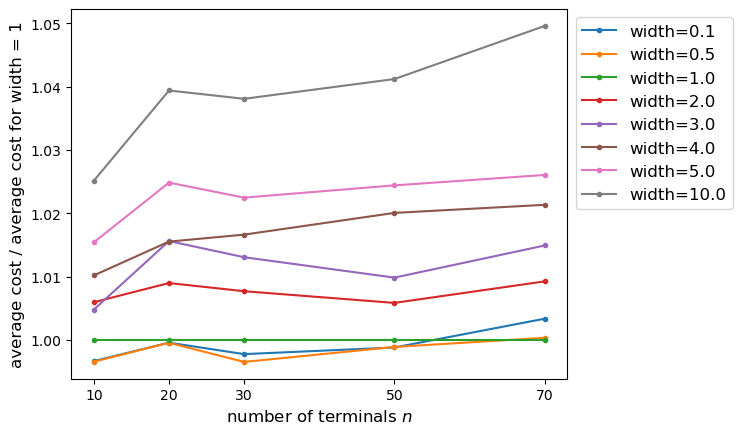

In [12]:
# divide by cost of width=1 approach
norm_mean_cost_arr = mean_cost_arr / (mean_cost_arr[:,2])[:,None]

for j,kernel_width in enumerate(kernel_width_arr):
    #plt.errorbar(num_terminals_arr, mean_iter_arr[:,j], yerr=std_iter_arr[:,j], fmt=".-", capsize=3, label=f"width={kernel_width}")
    plt.plot(num_terminals_arr, norm_mean_cost_arr[:,j], marker=".", linestyle="-", label=f"width={kernel_width}")

plt.legend(fontsize= 12, bbox_to_anchor=(1, 1))
plt.ylabel("average cost / average cost for width = 1", fontsize= 12)
plt.xlabel("number of terminals $n$", fontsize= 12)
plt.xticks(num_terminals_arr)
#plt.savefig("iter_conv.pdf", bbox_inches="tight")
plt.show()

## Comparison of the number of iterations (speed of the 

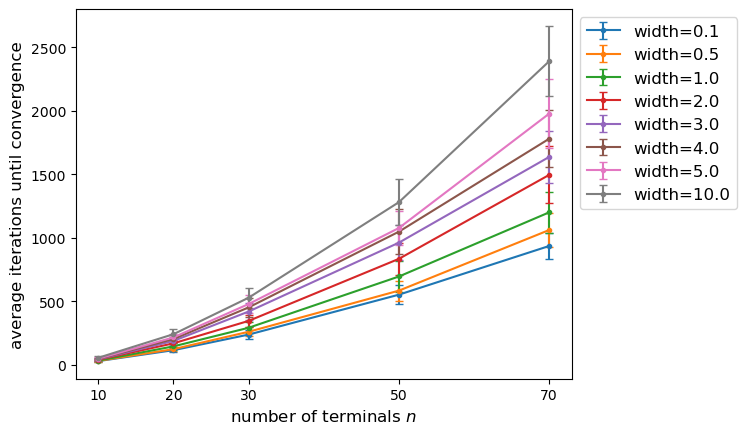

In [13]:
for j,kernel_width in enumerate(kernel_width_arr):
    plt.errorbar(num_terminals_arr, mean_iter_arr[:,j], yerr=std_iter_arr[:,j], fmt=".-", capsize=3, label=f"width={kernel_width}")

plt.legend(fontsize= 12, bbox_to_anchor=(1, 1))
plt.ylabel("average iterations until convergence", fontsize= 12)
plt.xlabel("number of terminals $n$", fontsize= 12)
plt.xticks(num_terminals_arr)
#plt.yscale("log")
#plt.xscale("log")
#plt.savefig("iter_conv.pdf", bbox_inches="tight")
plt.show()

Interpretation: It makes sense that optimization with the larger kernel takes longer as larger jumps are allowed and in the end one may select not helpful edges and then terminate. For wider kernel one would need a looser convergence criterion to get equally good results. For too small kerenels the algorithm is not explorative enough.

## Investigate the scaling simply by fitting a curve

c= [0.90679076 1.63410889]


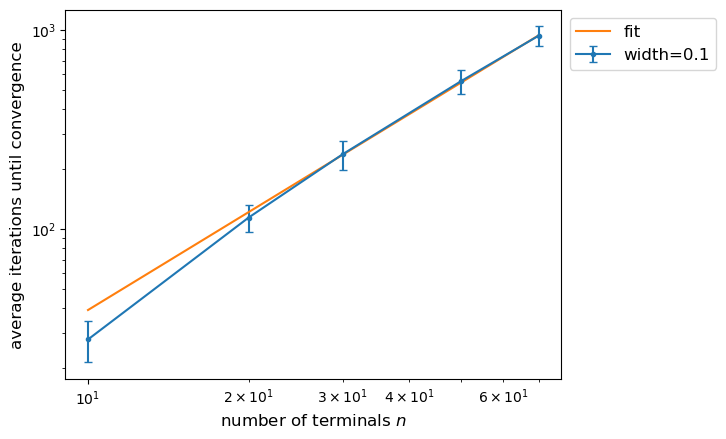

c= [0.70949594 1.71983005]


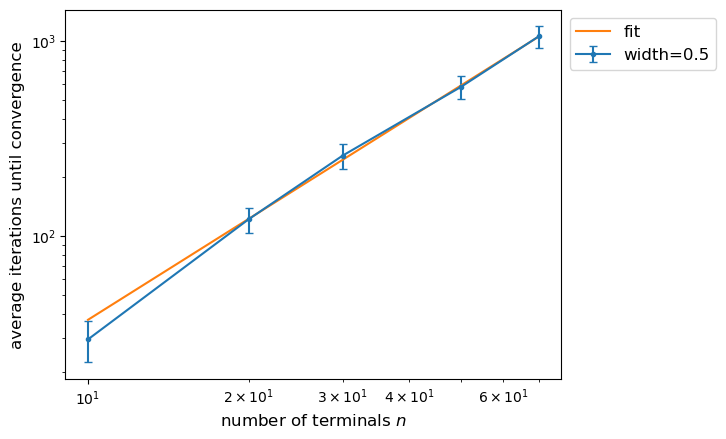

c= [0.97353927 1.67585474]


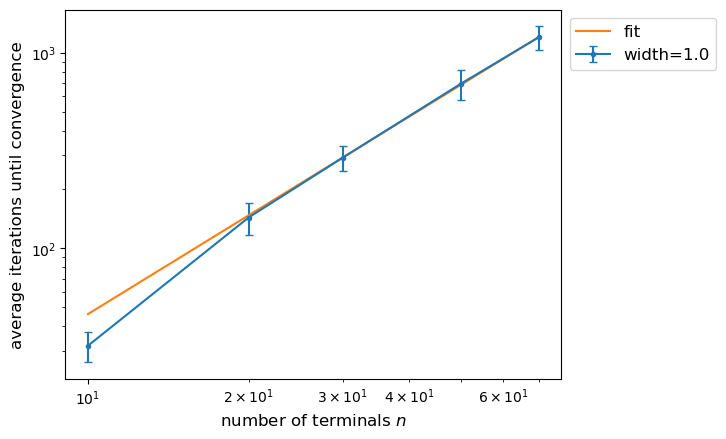

c= [0.90790759 1.74341628]


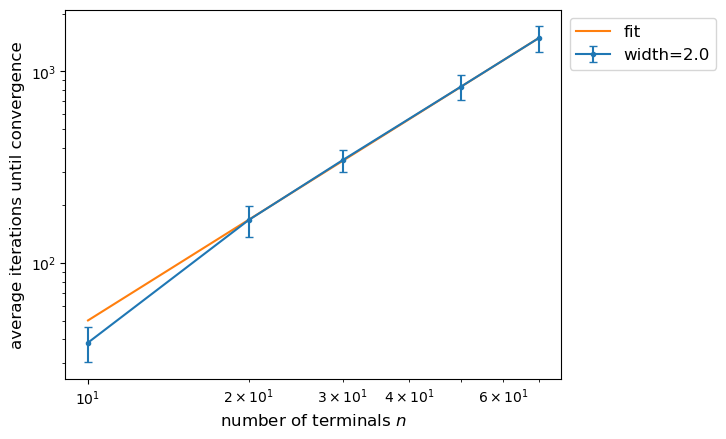

c= [1.50167856 1.64726437]


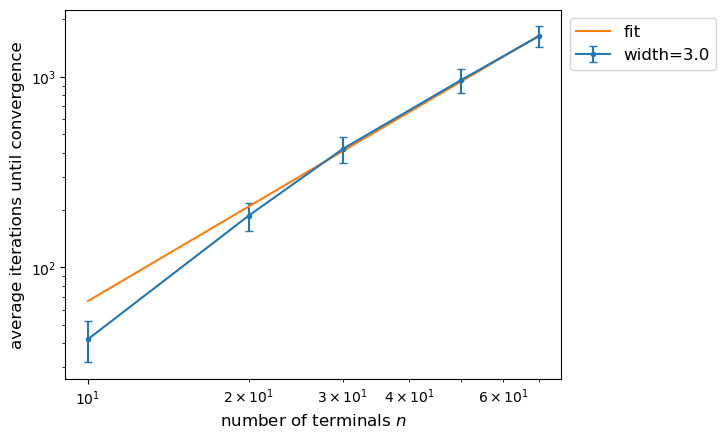

c= [1.60013237 1.65224085]


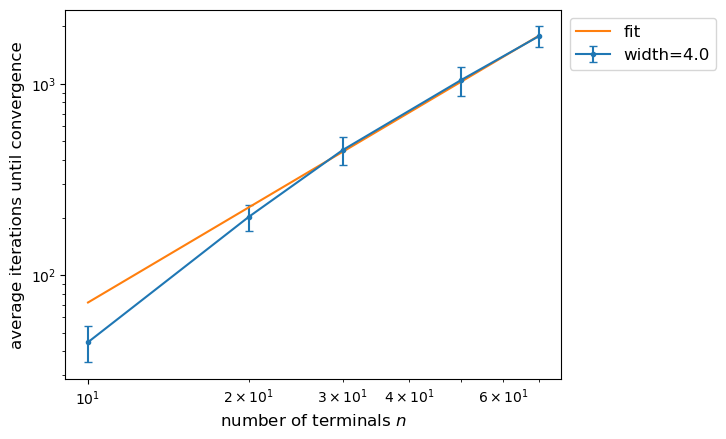

c= [1.1731919 1.748139 ]


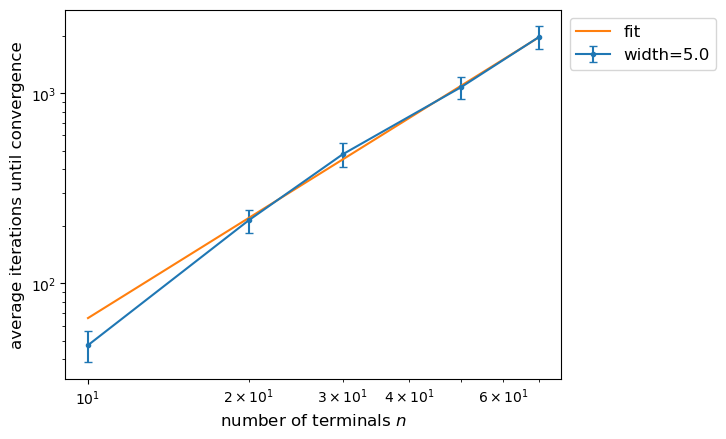

c= [1.02490715 1.82487144]


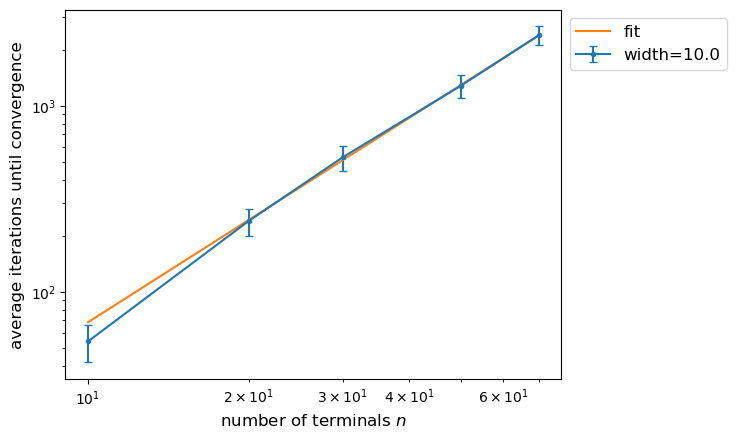

In [14]:
from scipy.optimize import curve_fit
def fit_fct_with_b(x, m, p, b):
    return m*x**p + b

def fit_fct(x, m, p):
    return m*x**p

p_arr = np.zeros(len(kernel_width_arr))
for j,kernel_width in enumerate(kernel_width_arr):
    c, cov = curve_fit(fit_fct, num_terminals_arr, mean_iter_arr[:,j], p0=[3, 1.4])
    #c, cov = curve_fit(fit_fct_with_b, num_terminals_arr, mean_iter_arr[:,j], p0=[3, 1.4, -30])
    p_arr[j] = c[1]
    
    # show the fit in log-log plot:
    plt.errorbar(num_terminals_arr, mean_iter_arr[:,j], yerr=std_iter_arr[:,j], fmt=".-", capsize=3, label=f"width={kernel_width}")
    plt.plot(num_terminals_arr, fit_fct(num_terminals_arr, *c), label="fit")
    #plt.plot(num_terminals_arr, fit_fct_with_b(num_terminals_arr, *c), label="fit")
    
    print("c=", c)
    plt.legend(fontsize= 12, bbox_to_anchor=(1, 1))
    plt.ylabel("average iterations until convergence", fontsize= 12)
    plt.xlabel("number of terminals $n$", fontsize= 12)
    plt.xticks(num_terminals_arr)
    plt.yscale("log")
    plt.xscale("log")
    #plt.savefig("iter_conv.pdf", bbox_inches="tight")
    plt.show()

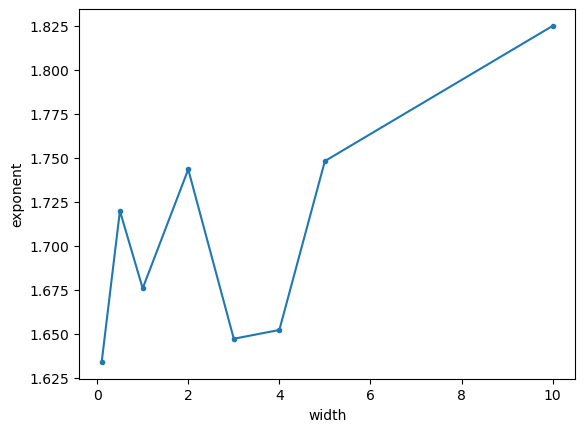

In [16]:
plt.plot(kernel_width_arr, p_arr, marker=".", linestyle="-")
plt.xlabel("width")
plt.ylabel("exponent")
plt.show()